In [395]:
## SETUP ##

import pandas as pd
import numpy as np
import timeit
from datetime import datetime, timedelta
from pytrends.request import TrendReq
from itertools import chain
import seaborn as sns
import string
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dictionary

In [193]:
data = pd.read_csv('/Users/mueric35/Desktop/inquireraugmented.csv', low_memory = False)

In [194]:
data = data.iloc[1:]
data = data[['Entry','Econ@','ECON','Positiv','Negativ','Pstv','Ngtv']]

In [195]:
data = data[ (data['Econ@'] == 'Econ@') | (data['ECON'] == 'ECON')]
index = (~data['Positiv'].isnull()) | ~(data['Negativ'].isnull()) | ~(data['Pstv'].isnull()) | ~(data['Ngtv'].isnull())
data = data[index]

In [196]:
temp = data[['Positiv','Negativ','Pstv','Ngtv']]
data[['Positiv','Negativ','Pstv','Ngtv']] = temp.notnull().astype(int)
data['Char'] = 0
data.loc[(data['Positiv'] == 1) | (data['Pstv'] == 1),'Char'] = 1
data.loc[~((data['Positiv'] == 1) | (data['Pstv'] == 1)),'Char'] = 0
data.loc[:,'Entry'] = data['Entry'].str.lower().str.split('#').str[0]

In [257]:
data.head()

,Entry,Econ@,ECON,Positiv,Negativ,Pstv,Ngtv,Char
51,abundance,NaN,ECON,1,0,1,0,1
97,accrue,Econ@,ECON,1,0,0,0,1
217,advantage,NaN,ECON,1,0,1,0,1
255,affluence,Econ@,NaN,1,0,0,0,1
256,affluent,Econ@,NaN,1,0,0,0,1


#### Primitive word list

In [265]:
final_dict = data[['Entry','Char']]
final_dict.reset_index(drop=True,inplace=True)
final_dict = final_dict.drop_duplicates()

In [268]:
final_dict.shape

(150, 2)

In [269]:
final_dict.head()

,Entry,Char
0,abundance,1
1,accrue,1
2,advantage,1
3,affluence,1
4,affluent,1


## Google Trend 

In [292]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

### import primitive word 

In [333]:
pri_word = final_dict['Entry'].tolist()


%timeit
word_lst = []
i = 0 
for word in pri_word:
    
    pytrends.build_payload([word], cat=16, timeframe='2010-01-01 2017-01-01', geo='US')
    
    series_queries = pytrends.related_queries()
    if     series_queries[word]['top'] is None:
        pass
    else:
        series_queries = series_queries[word]['top']['query']
        word_lst.append(series_queries[:10].tolist())

    time.sleep(randint(5, 10))
    i+=1

In [445]:
Word_lst = word_lst
Word_lst = list(chain.from_iterable(Word_lst))

In [654]:
# remove duplicate
Word_lst = list(set(Word_lst))
len(Word_lst)

960

### Save File 

In [770]:
Word_list = open('/Users/mueric35/Desktop/project/word_list.txt', 'w')
for word in Word_lst:
    Word_list.write("%s\n" % word)


### Read File

In [771]:
with open('/Users/mueric35/Desktop/project/word_list.txt', 'r') as f:
    Word_lst = f.read().splitlines() 

In [772]:
%time

# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()

#word_dict = []
#count = 0
#reset_overlap = []

for word in Word_lst[37:]:
    
    kw_list = [word]
    
    # The maximum for a timeframe for which we get daily data is 270.
    # Therefore we could go back 269 days. However, since there might
    # be issues when rescaling, e.g. zero entries, we should have an
    # overlap that does not consist of only one period. Therefore,
    # I limit the step size to 250. This leaves 19 periods for overlap.
    maxstep = 269
    overlap = 50
    step = maxstep - overlap + 1
    start_date = datetime(2010, 1, 1).date()

    ## FIRST RUN ##

    
    # Run the first time (if we want to start from today, otherwise we need to ask for an end_date as well
    today = datetime.today().date()
    old_date = today

    # Go back in time
    new_date = today - timedelta(days=step)

    # Create new timeframe for which we download data
    timeframe = new_date.strftime('%Y-%m-%d')+' '+old_date.strftime('%Y-%m-%d')
    pytrend.build_payload(kw_list= kw_list, cat = 16 ,timeframe = timeframe)
    interest_over_time_df = pytrend.interest_over_time()

    ## RUN ITERATIONS
    
    
    while new_date > start_date:

        ### Save the new date from the previous iteration.
        # Overlap == 1 would mean that we start where we
        # stopped on the iteration before, which gives us
        # indeed overlap == 1.
        old_date = new_date + timedelta(days=overlap-1)

        ### Update the new date to take a step into the past
        # Since the timeframe that we can apply for daily data
        # is limited, we use step = maxstep - overlap instead of
        # maxstep.
        new_date = new_date - timedelta(days=step)
        # If we went past our start_date, use it instead
        if new_date < start_date:
            new_date = start_date

        # New timeframe
        timeframe = new_date.strftime('%Y-%m-%d')+' '+old_date.strftime('%Y-%m-%d')
            #print(timeframe)

        # Download data
        pytrend.build_payload(kw_list=kw_list, timeframe = timeframe)
        
        time.sleep(randint(5, 10))
        
        temp_df = pytrend.interest_over_time()
        if (temp_df.empty):
            print('Sent back empty dataframe: ' + word + ', skip!' + "\n")
            interest_over_time_df = temp_df
            break
            #raise ValueError('Google sent back an empty dataframe. Possibly there were no searches at all during the this period! Set start_date to a later date.')
        # Renormalize the dataset and drop last line
        for kw in kw_list:
            beg = new_date
            end = old_date - timedelta(days=1)

            # Since we might encounter zeros, we loop over the
            # overlap until we find a non-zero element
            for t in range(1,overlap+1):
                #print('t = ',t)
                #print(temp_df[kw].iloc[-t])
                if temp_df[kw].iloc[-t] != 0:
                    scaling = interest_over_time_df[kw].iloc[t-1]/temp_df[kw].iloc[-t]
                    #print('Found non-zero overlap!')
                    break
                elif t == overlap:
                    print('Did not find non-zero overlap, set scaling to zero! Increase Overlap!')
                    reset_overlap.append(word)
                    scaling = 0
                    
            # Apply scaling
            temp_df.loc[beg:end,kw]=temp_df.loc[beg:end,kw]*scaling
        interest_over_time_df = pd.concat([temp_df[:-overlap],interest_over_time_df])

    # filter 
    if interest_over_time_df.shape[0] > 1000:
        word_json = interest_over_time_df.iloc[:,:1].to_json()

        # append word 
        word_dict.append(word_json)
        #pd.to_datetime(1262476800000,unit = 'ms')

    else:
        print('Skip: ' + word + "\n")
    count += 1 
    print('Finished' + ' ' + str(count) + " : " + word + "\n")
    time.sleep(randint(5, 10))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


ResponseError: The request failed: Google returned a response with code 503.

In [687]:
a = word_dict

### Save 

In [774]:
filehandler = open('/Users/mueric35/Desktop/project/word_dict.pkl', 'wb') 
pickle.dump(word_dict, filehandler) 

### Read  

In [775]:
with open('/Users/mueric35/Desktop/project/word_dict.pkl', 'rb')  as f:
    dump = pickle.load(f)

### Plot

most expensive stock


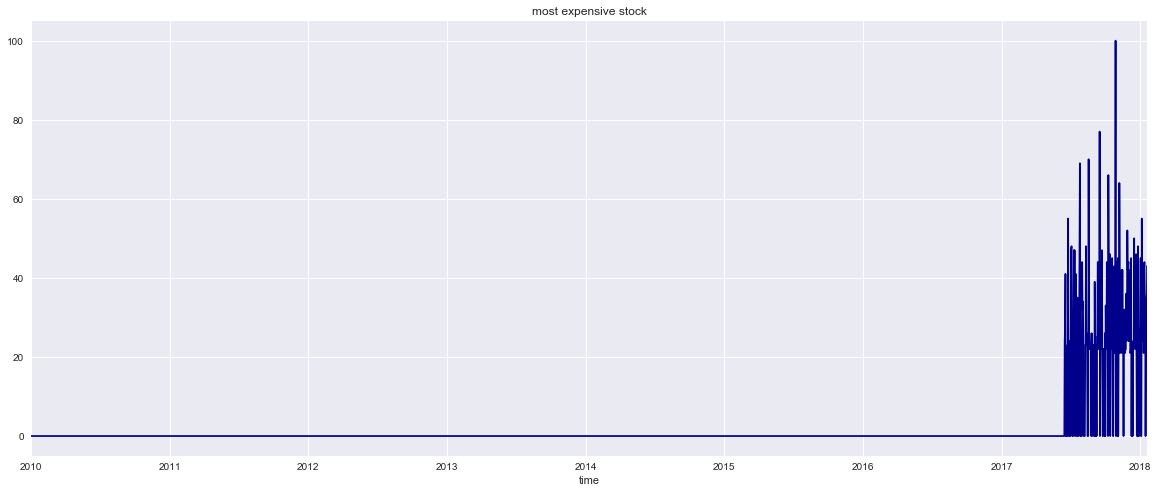

an abundance of katherines


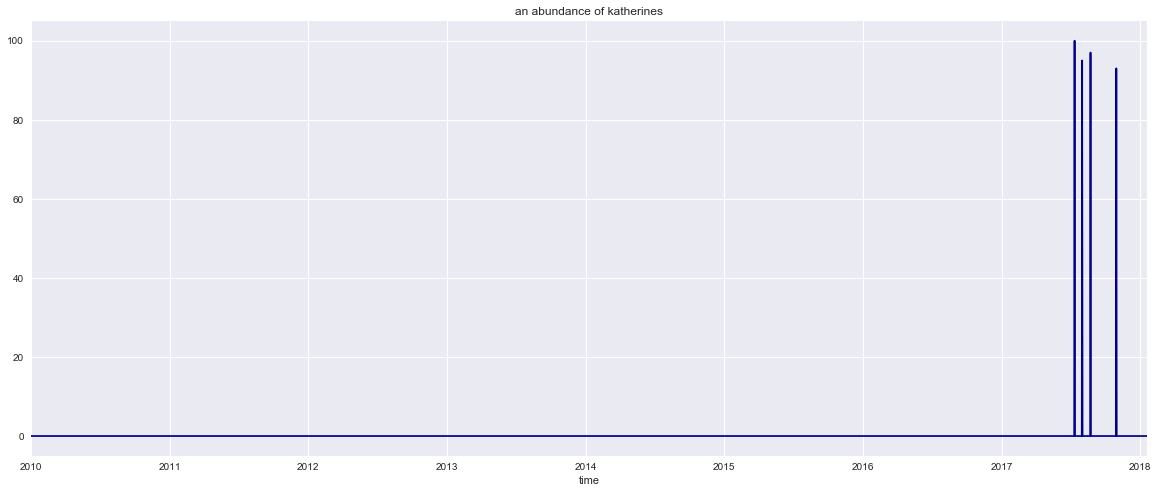

boom town


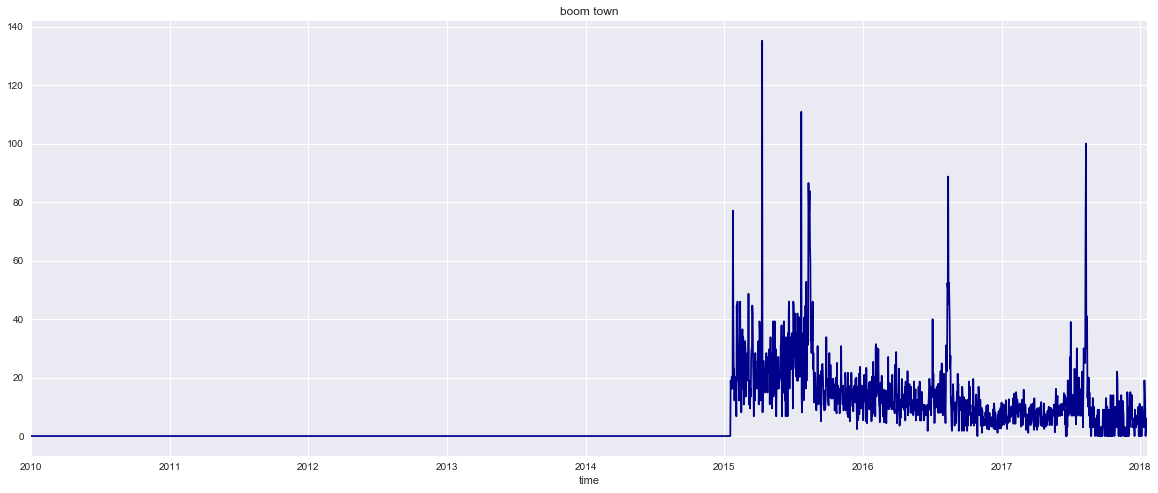

frugal living


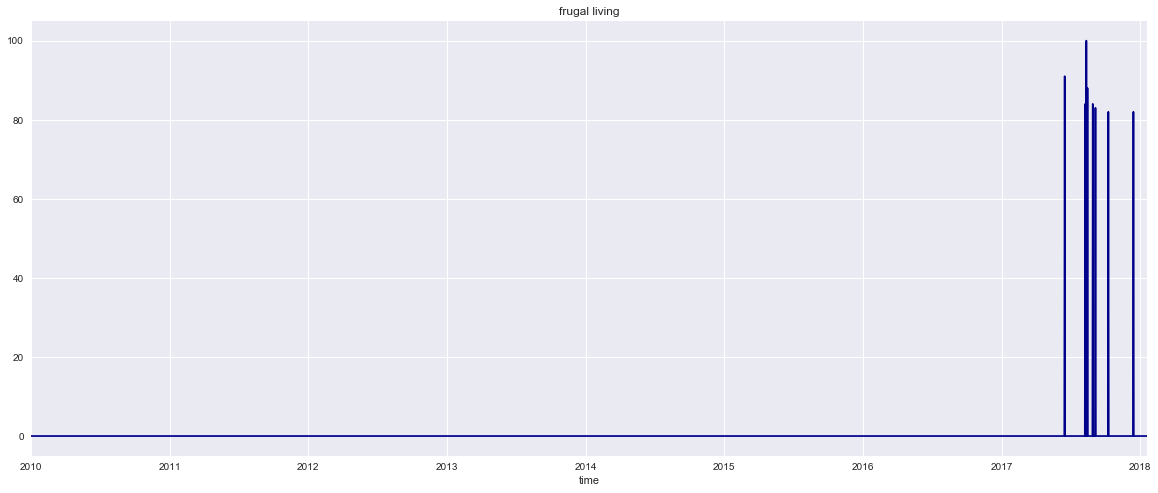

budget deficit


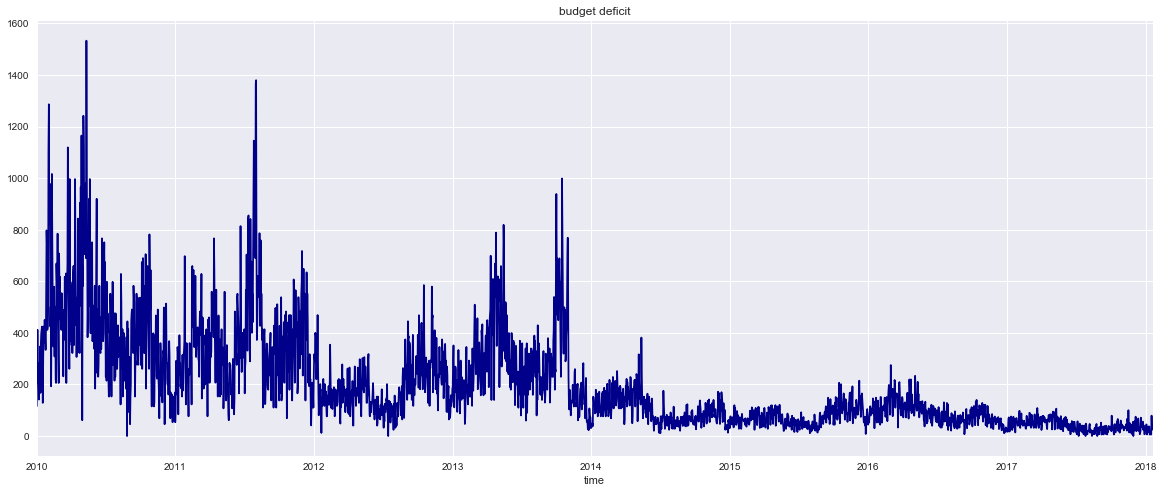

continued health care benefit program


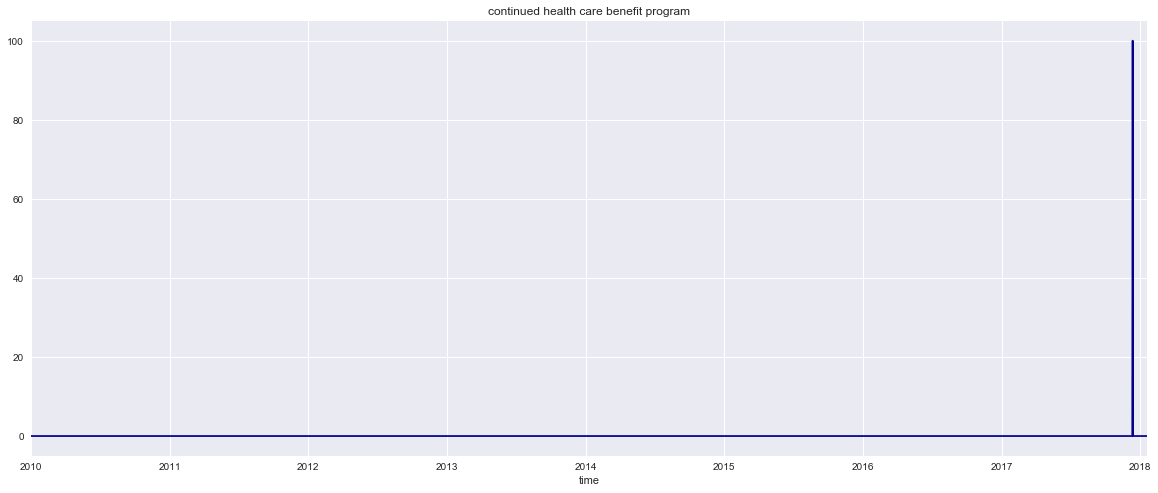

americans for prosperity


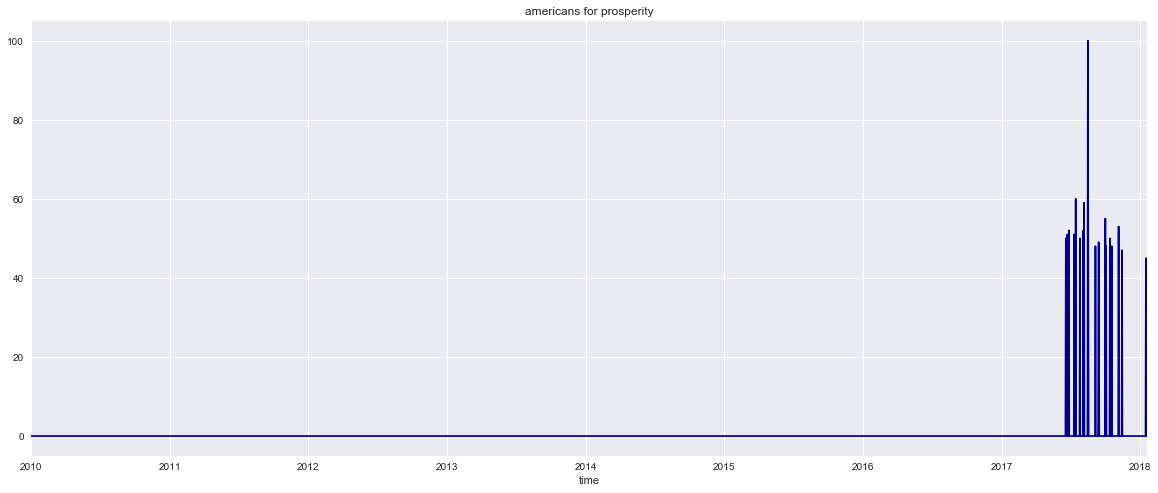

detroit media partnership


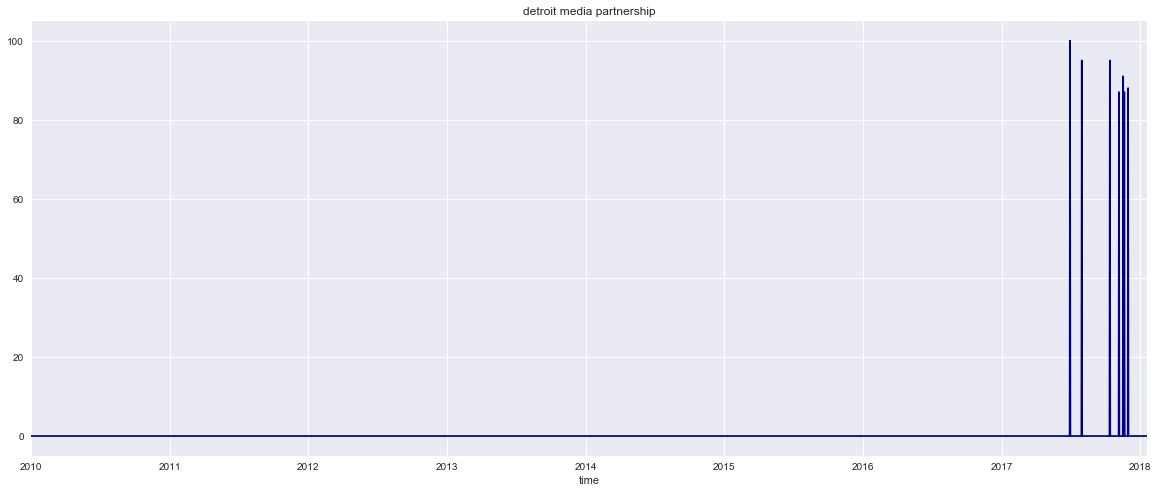

healthcare


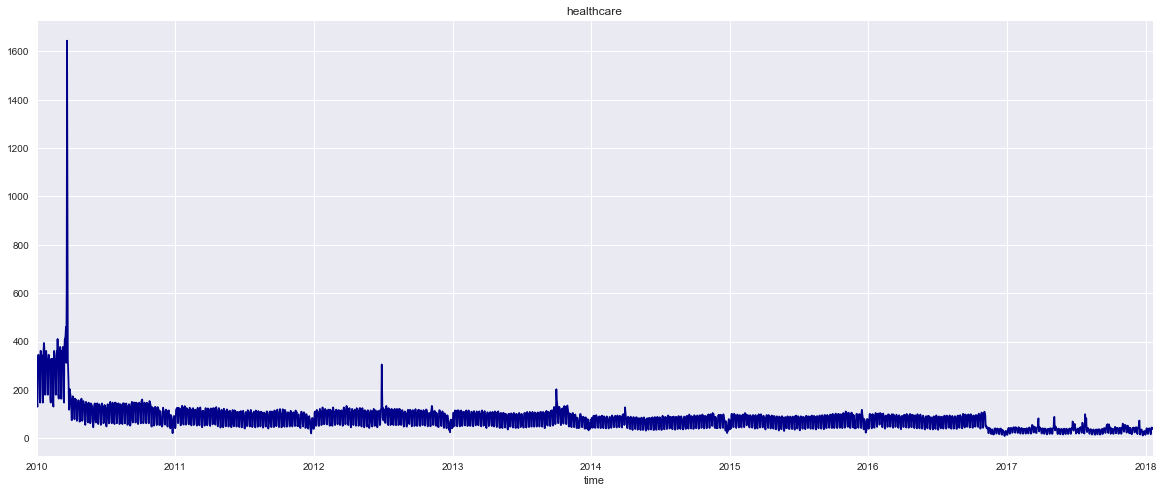

ass hole


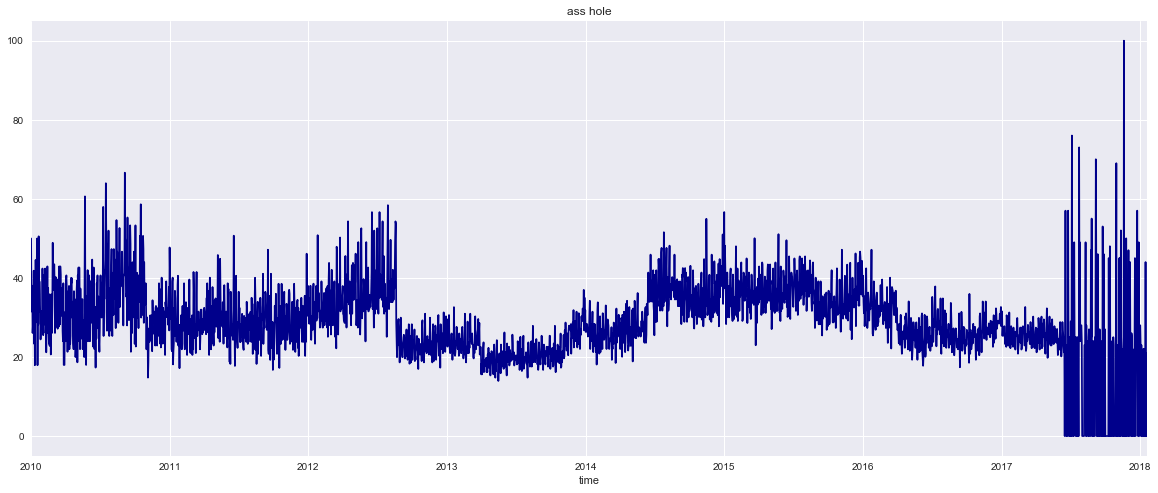

clinton foundation


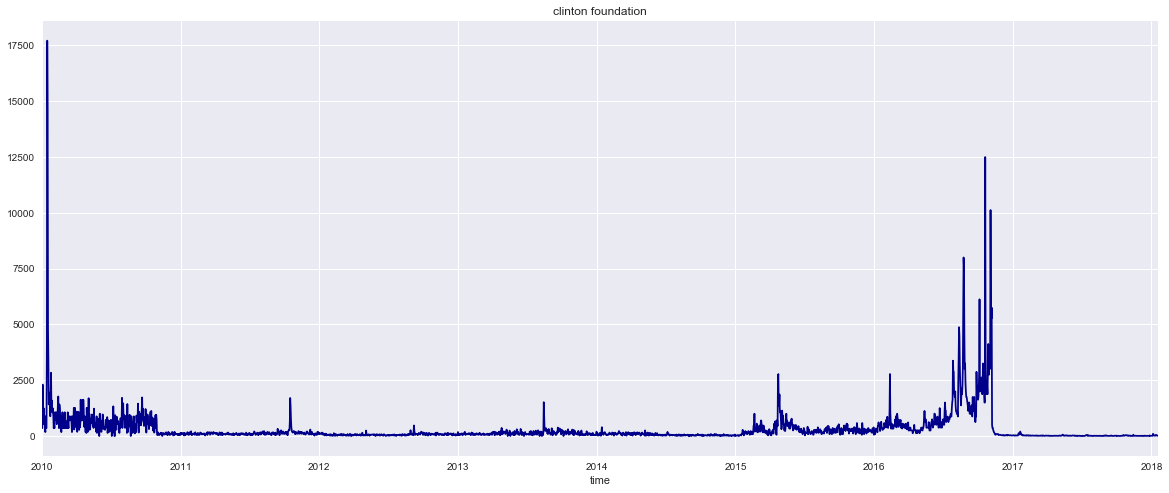

fire news


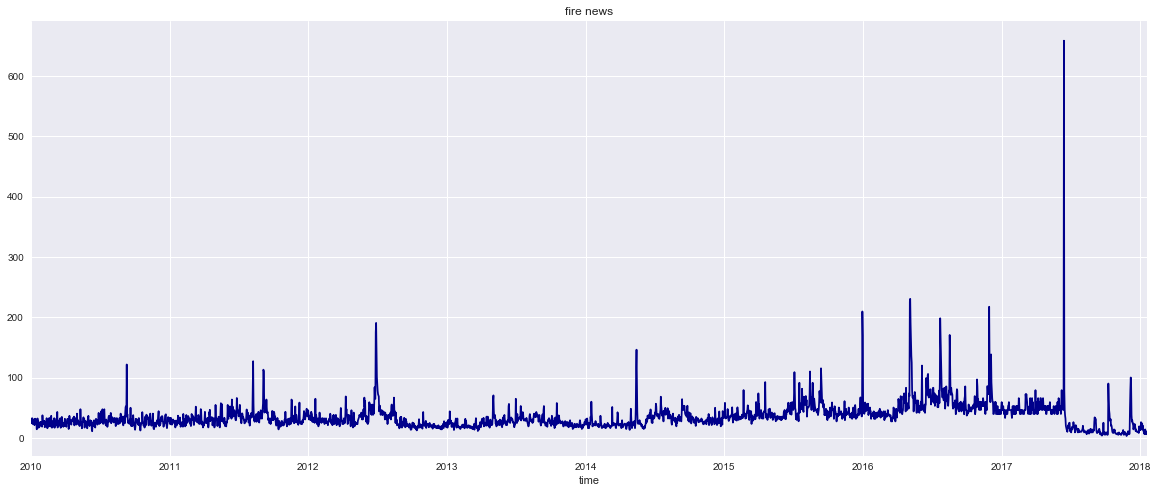

payne aldrich tariff


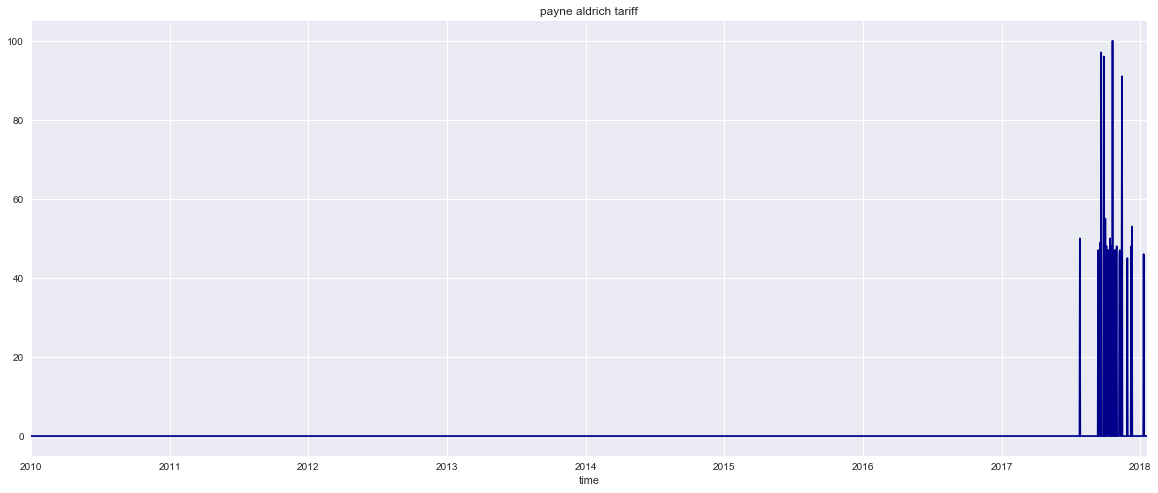

campaign contributions


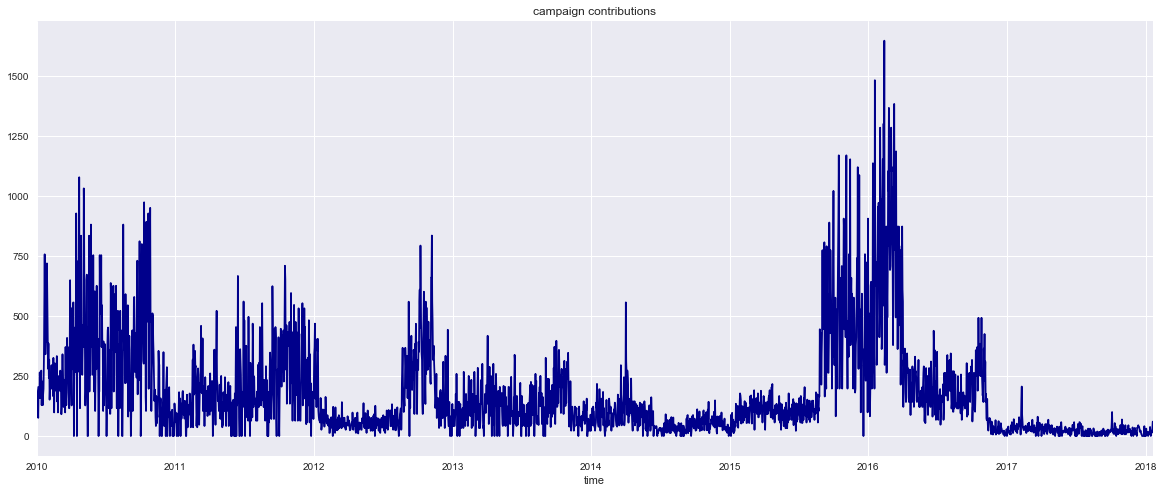

rich people


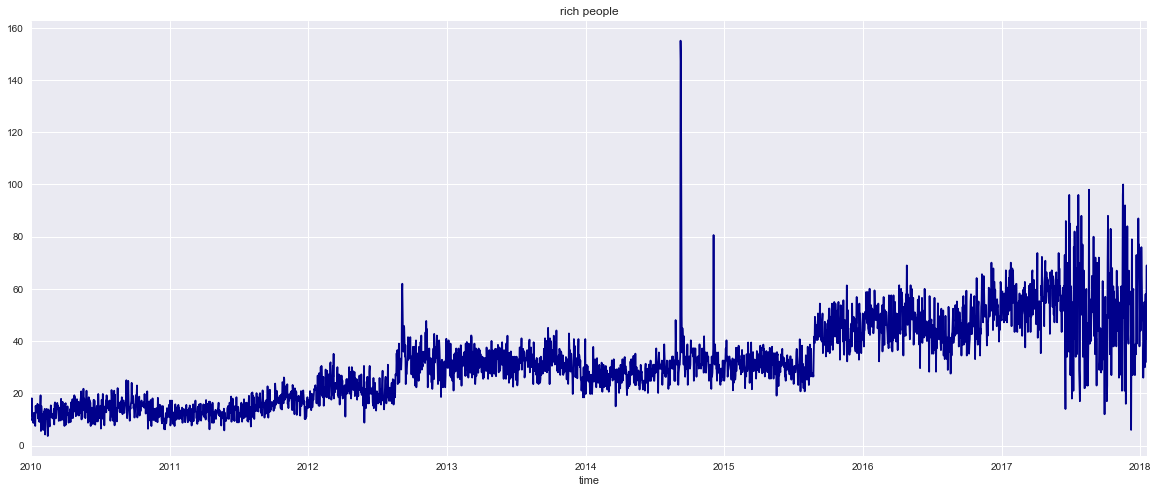

prosperity economics


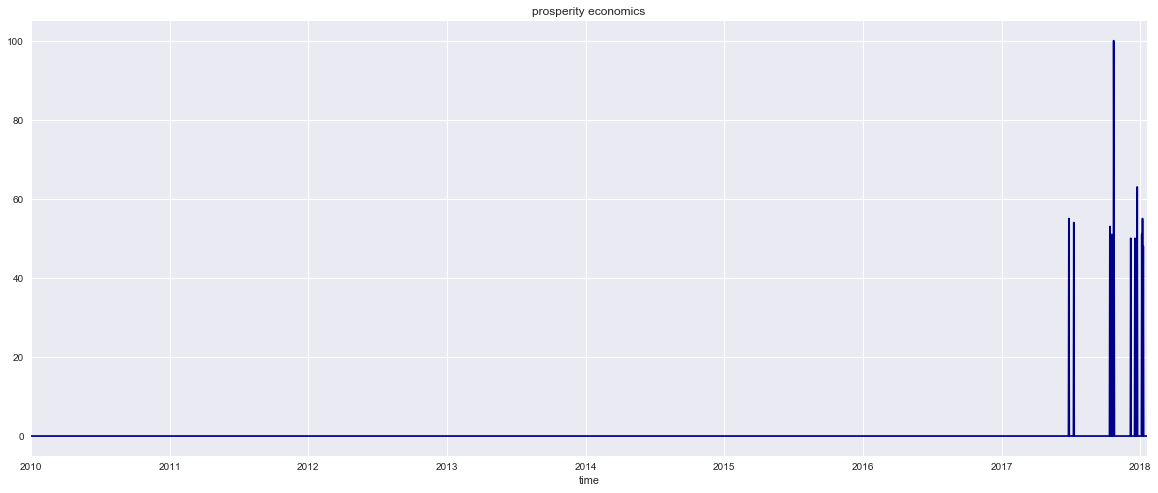

federal deficit


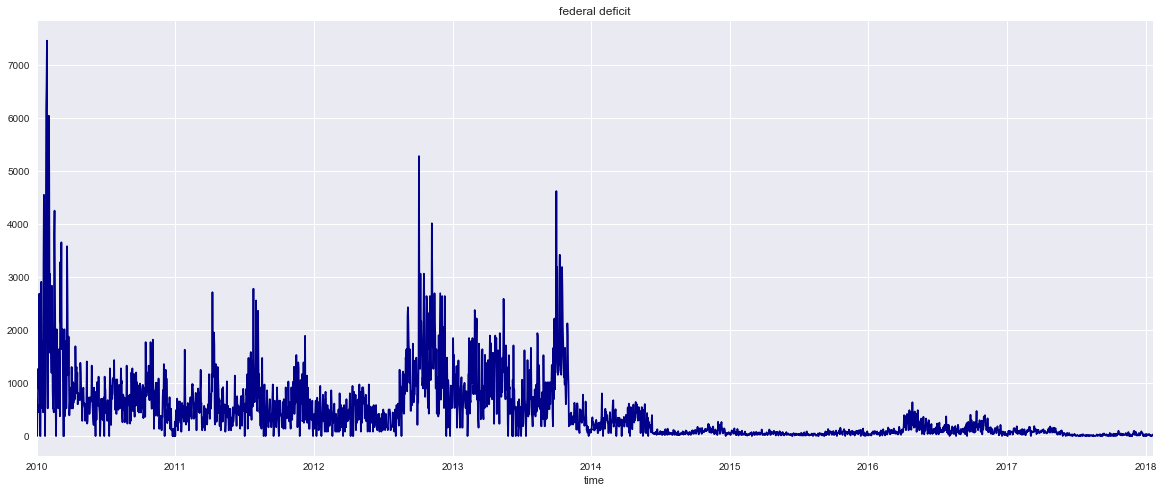

treasure hunt


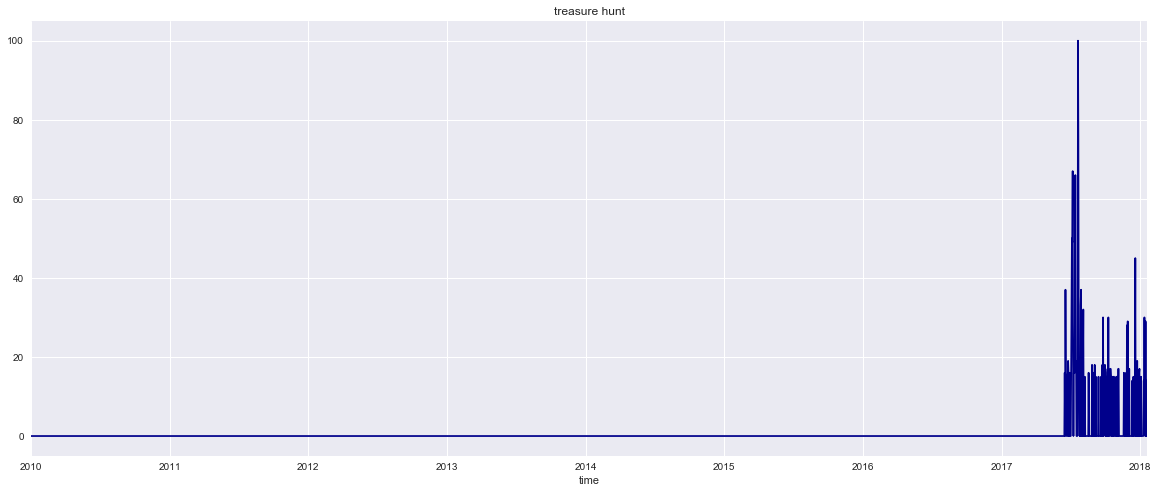

benefit definition


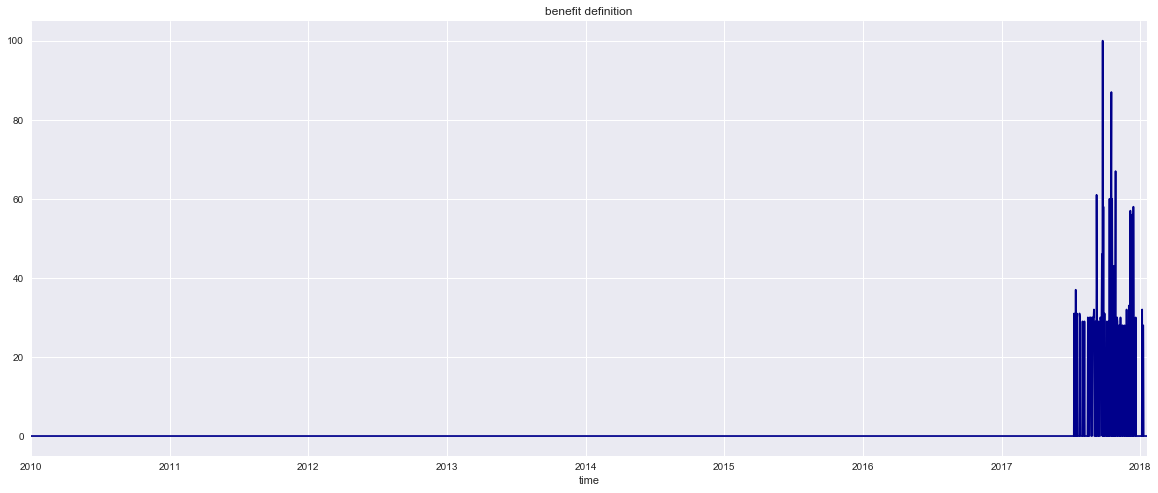

healthcare fine


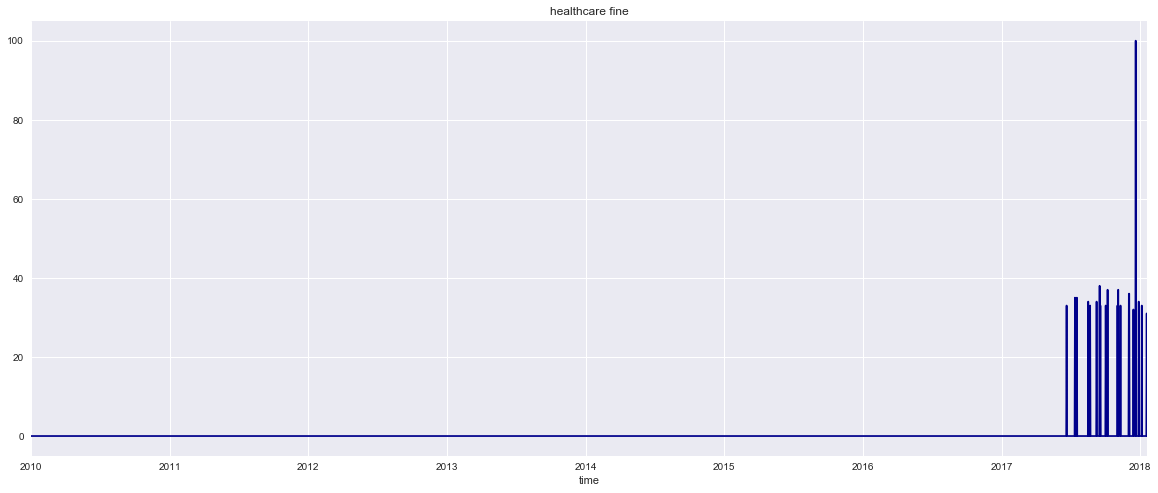

dividend aristocrats


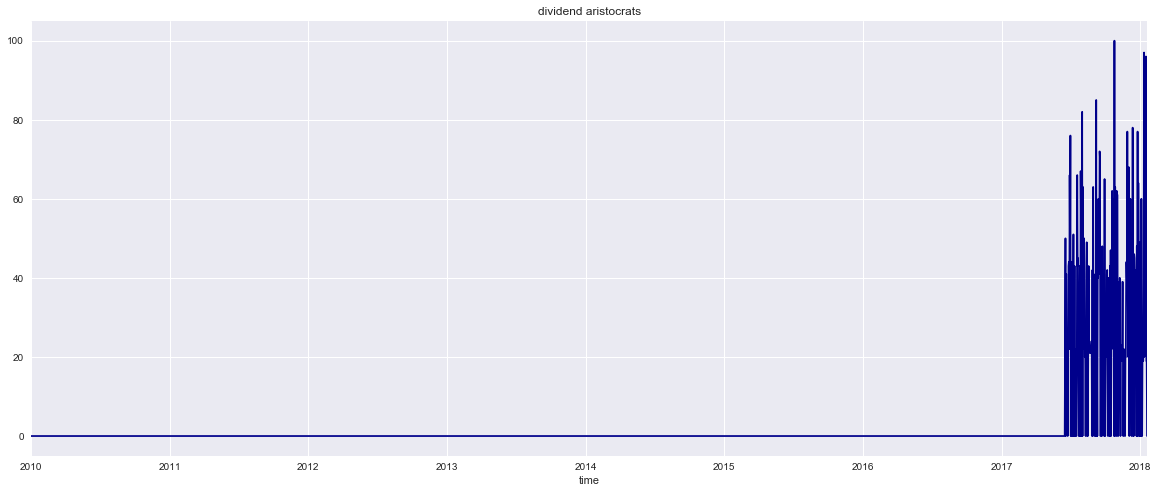

tsp beneficiary form


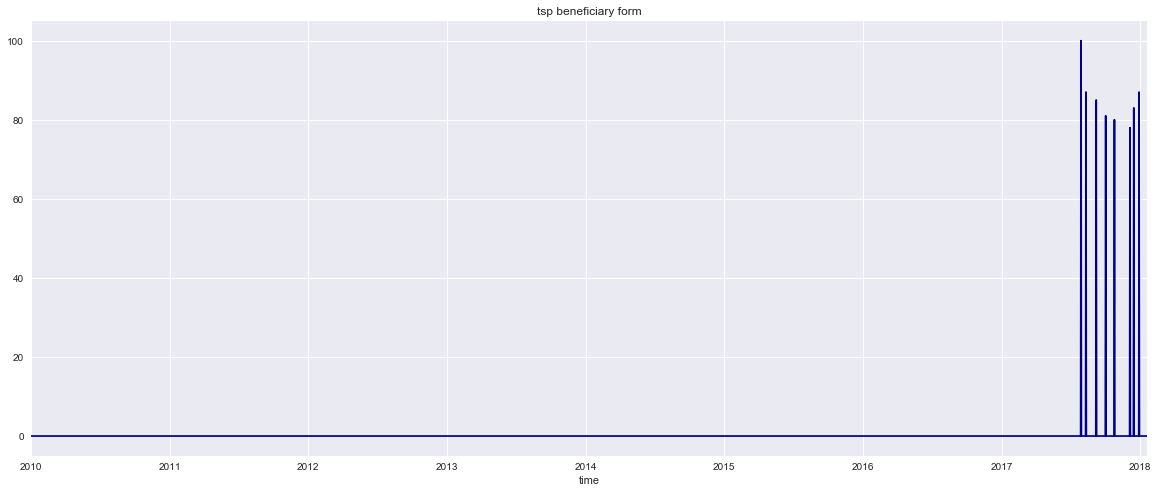

debt clock


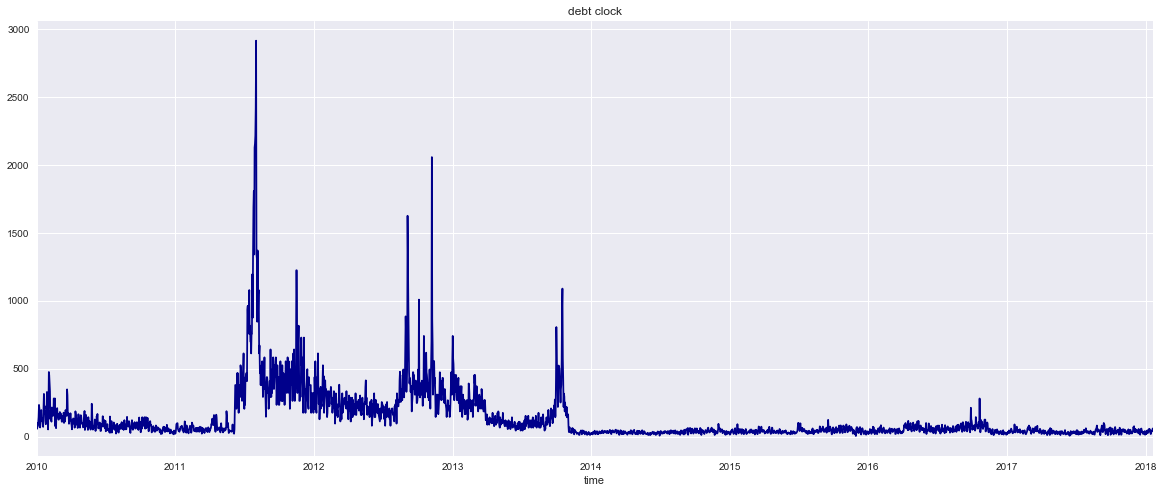

steal her style


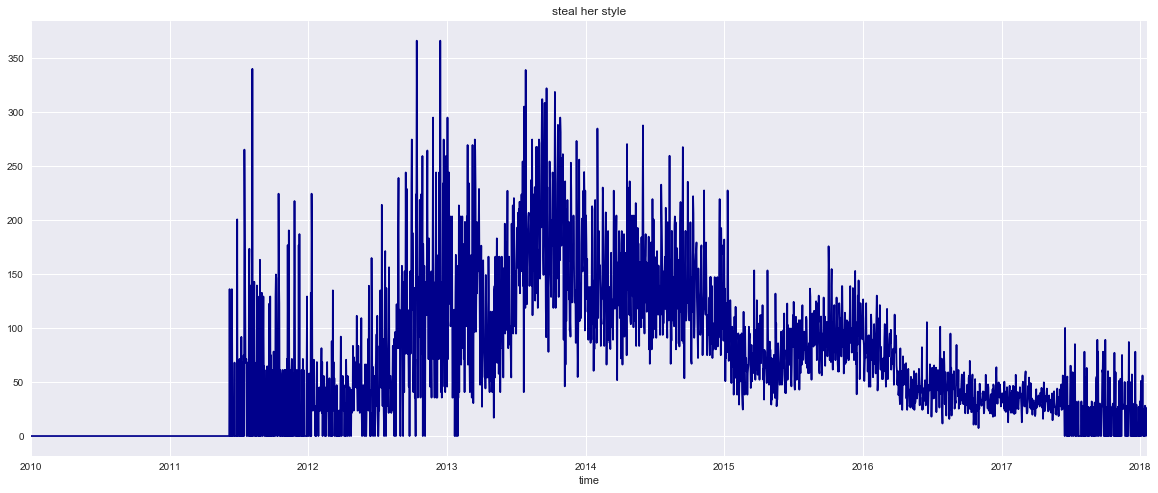

underworld awakening


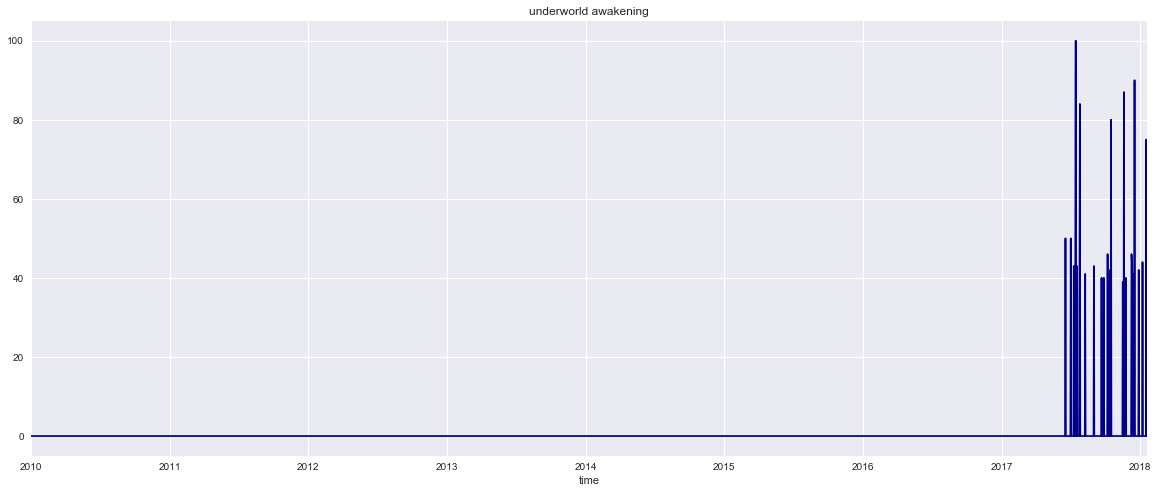

kelly clarkson weight gain


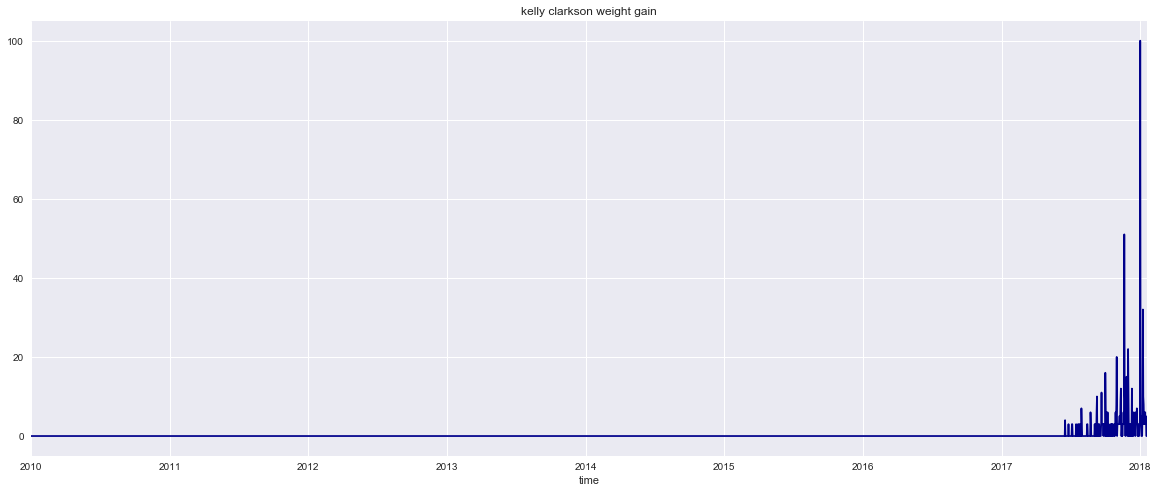

tv guide news


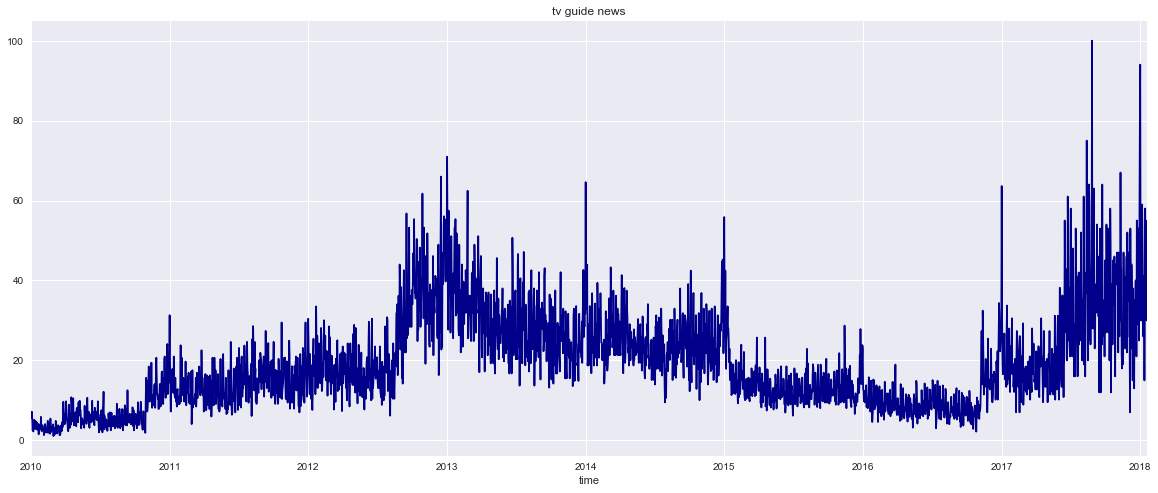

apple stock


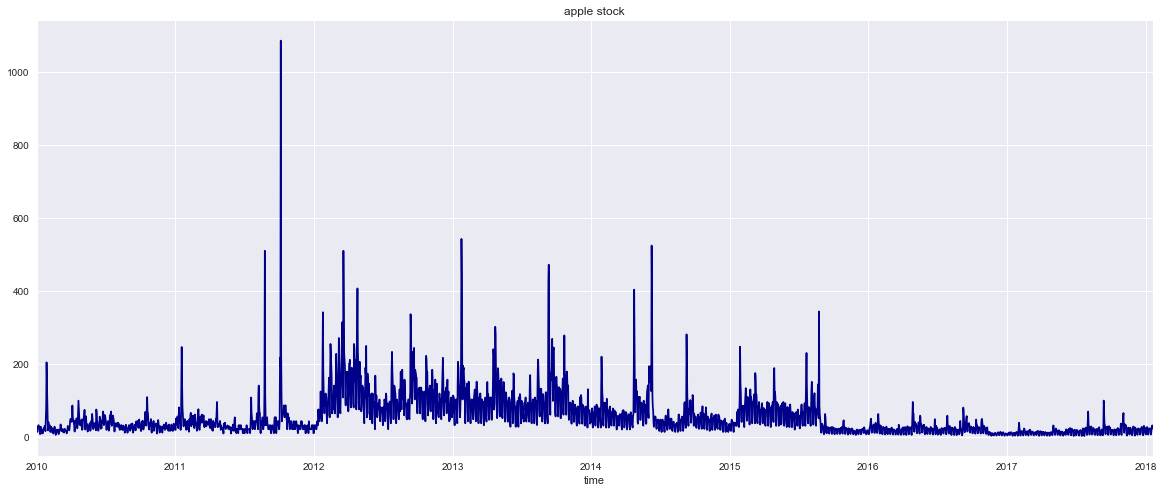

jessica simpson weight gain


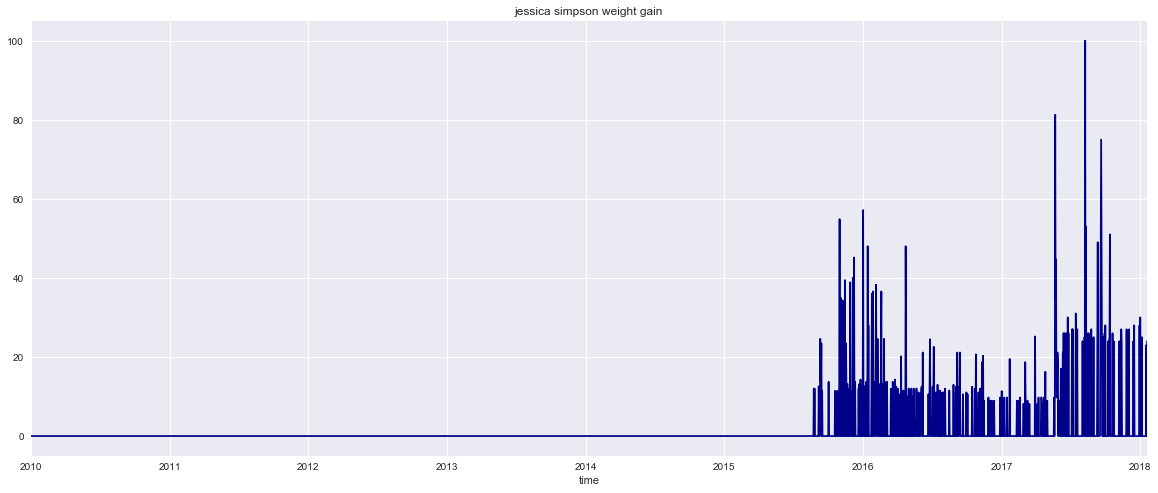

community bank


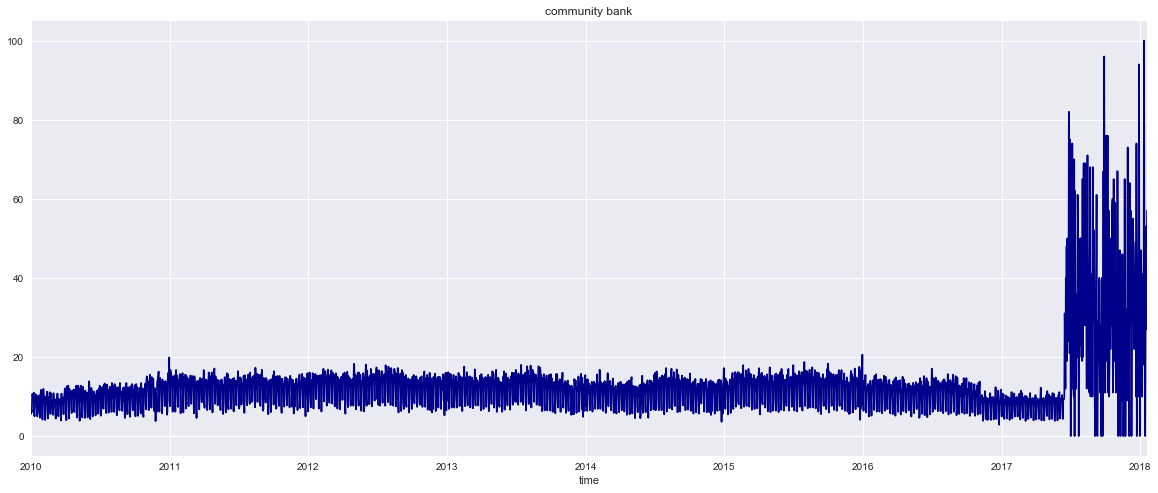

charitable contributions


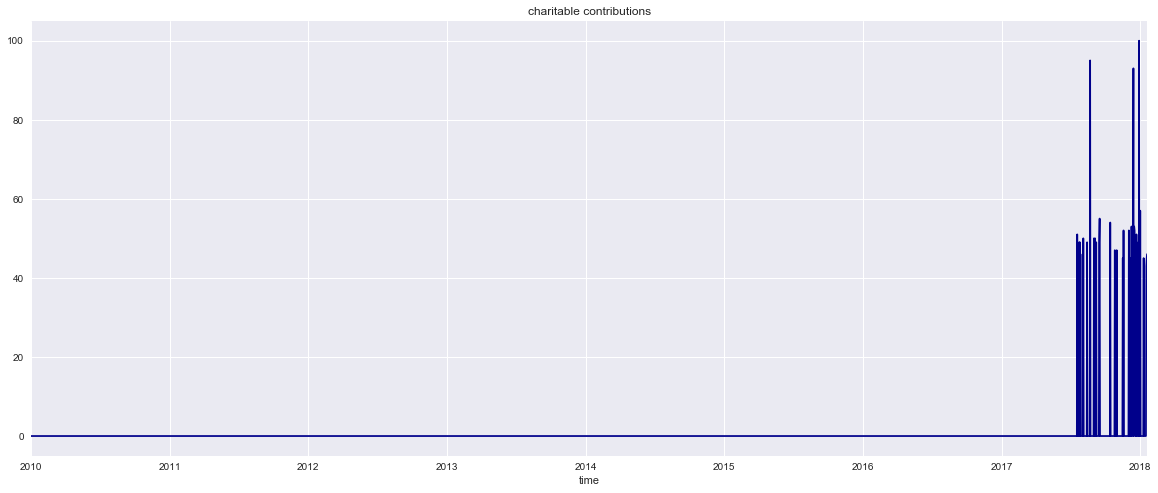

intervention definition


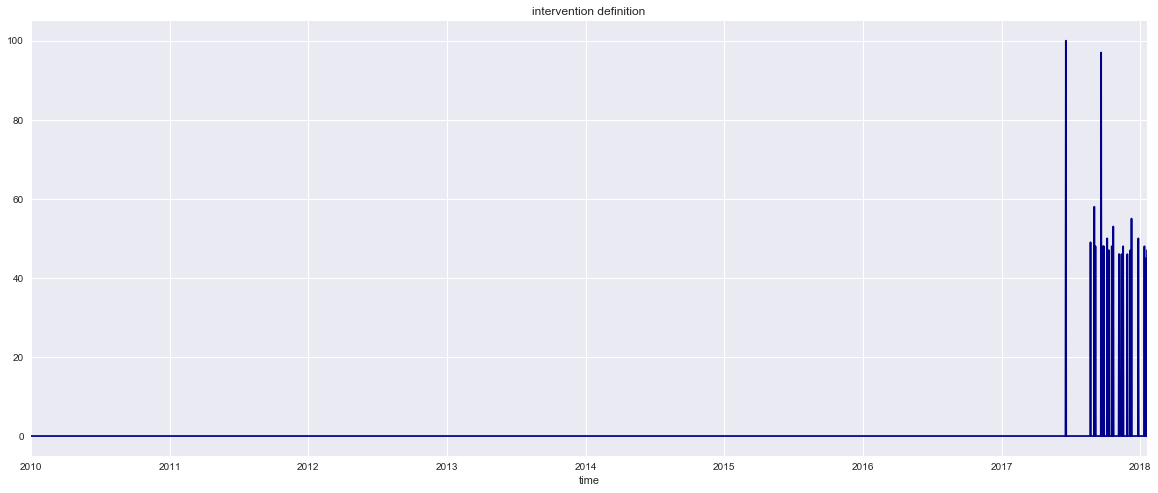

In [778]:
from pandas import Series
for i in range(len(a)):
    temp = pd.read_json(a[i]).reset_index()
    topic = temp.columns[1]
    print(topic)
    temp.columns = ['time','count']
    count =  np.array(temp['count'])
    count.astype(int)
    pp = Series(count, index= temp.time)
    plt.figure(figsize = (20,8))
    plt.title(str(topic))
    pp.plot(color = 'darkblue')
    plt.show()